# Raw data
After the issue importing the data to MySQL, we continued the analysis in python. The original file ("lc_loans") was uploaded to a jupyer notebook and there were errors in some rows. Maybe the first line with an error in the data was line 28908 and MySQL stopped there without importing the next lines with no errors. We can do that in python:

In [ ]:
# import pandas as pd
# try:
#     df = pd.read_csv("/content/lc_loan.csv", on_bad_lines='skip')
#     print("df Loaded with bad lines skipped.")
# except Exception as e:
#     print(f"An error occurred: {e}")

The shape is (887379, 75). Since the database in MySQL had 28K rows only, we will verify the data is clean with python again. Also, we will select only the relevant columns for the analysis:

In [ ]:
# interesting_columns = [
#     'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
#     'grade', 'annual_inc', 'dti', 'loan_status', 'purpose',
#     'total_pymnt', 'total_rec_int', 'total_rec_prncp''issue_d',
#     'sub_grade', 'home_ownership', 'emp_length', 'verification_status',
#     'delinq_2yrs', 'open_acc', 'total_acc', 'revol_util', 'addr_state'
# ]

# df_selected = df[interesting_columns]

# df_selected.to_csv("lc_loan_staged.csv", index=False)

# Data cleaning and initial Exploratory Data Analysis

In [51]:
import pandas as pd
import numpy as np

# Load the CSV file into a DataFrame
df = pd.read_csv("lc_loan_staged.csv")

In [52]:
df.shape

(887379, 23)

In [53]:
df.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,annual_inc,dti,loan_status,purpose,...,issue_d,sub_grade,home_ownership,emp_length,verification_status,delinq_2yrs,open_acc,total_acc,revol_util,addr_state
0,5000.0,5000.0,36 months,10.65,162.87,B,24000.0,27.65,Fully Paid,credit_card,...,Dec-2011,B2,RENT,10+ years,Verified,0.0,3.0,9.0,83.7,AZ
1,2500.0,2500.0,60 months,15.27,59.83,C,30000.0,1.00,Charged Off,car,...,Dec-2011,C4,RENT,< 1 year,Source Verified,0.0,3.0,4.0,9.4,GA
2,2400.0,2400.0,36 months,15.96,84.33,C,12252.0,8.72,Fully Paid,small_business,...,Dec-2011,C5,RENT,10+ years,Not Verified,0.0,2.0,10.0,98.5,IL
3,10000.0,10000.0,36 months,13.49,339.31,C,49200.0,20.00,Fully Paid,other,...,Dec-2011,C1,RENT,10+ years,Source Verified,0.0,10.0,37.0,21.0,CA
4,3000.0,3000.0,60 months,12.69,67.79,B,80000.0,17.94,Current,other,...,Dec-2011,B5,RENT,1 year,Source Verified,0.0,15.0,38.0,53.9,OR


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            887379 non-null  float64
 1   funded_amnt          887379 non-null  float64
 2   term                 887379 non-null  object 
 3   int_rate             887379 non-null  float64
 4   installment          887379 non-null  float64
 5   grade                887379 non-null  object 
 6   annual_inc           887375 non-null  float64
 7   dti                  887379 non-null  float64
 8   loan_status          887379 non-null  object 
 9   purpose              887379 non-null  object 
 10  total_pymnt          887379 non-null  float64
 11  total_rec_int        887379 non-null  float64
 12  total_rec_prncp      887379 non-null  float64
 13  issue_d              887379 non-null  object 
 14  sub_grade            887379 non-null  object 
 15  home_ownership   

Delete rows with null values, without affecting the analysis since they are a very small fraction:

In [55]:
df = df.dropna(subset=['emp_length'])

Convert term to float:

In [56]:
df['term'] = df['term'].str.extract('(\d+)').astype(float)

Convert issue_d to date:

In [57]:
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

Add a column with emp_lenght in int:

In [58]:
def convert_emp_length(emp_str):
    if pd.isnull(emp_str) or emp_str.strip().lower() in ['n/a', 'none']:
        return np.nan
    # Convert "< 1 year" to 0
    if '<' in emp_str:
        return 0
    # If "10+ years", remove '+' and extract the number (treating "10+ years" as 10)
    if '+' in emp_str:
        return int(emp_str.split('+')[0])
    # For other strings like "2 years", "7 years", etc., extract the first number
    return int(emp_str.split()[0])

# Create a new integer column for employment length
df['emp_length_int'] = df['emp_length'].apply(convert_emp_length)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 842554 entries, 0 to 887378
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   loan_amnt            842554 non-null  float64       
 1   funded_amnt          842554 non-null  float64       
 2   term                 842554 non-null  float64       
 3   int_rate             842554 non-null  float64       
 4   installment          842554 non-null  float64       
 5   grade                842554 non-null  object        
 6   annual_inc           842550 non-null  float64       
 7   dti                  842554 non-null  float64       
 8   loan_status          842554 non-null  object        
 9   purpose              842554 non-null  object        
 10  total_pymnt          842554 non-null  float64       
 11  total_rec_int        842554 non-null  float64       
 12  total_rec_prncp      842554 non-null  float64       
 13  issue_d            

In [60]:
df = df.dropna(subset=['revol_util'])

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 842067 entries, 0 to 887378
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   loan_amnt            842067 non-null  float64       
 1   funded_amnt          842067 non-null  float64       
 2   term                 842067 non-null  float64       
 3   int_rate             842067 non-null  float64       
 4   installment          842067 non-null  float64       
 5   grade                842067 non-null  object        
 6   annual_inc           842067 non-null  float64       
 7   dti                  842067 non-null  float64       
 8   loan_status          842067 non-null  object        
 9   purpose              842067 non-null  object        
 10  total_pymnt          842067 non-null  float64       
 11  total_rec_int        842067 non-null  float64       
 12  total_rec_prncp      842067 non-null  float64       
 13  issue_d            

In [62]:
df.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,annual_inc,dti,loan_status,purpose,...,sub_grade,home_ownership,emp_length,verification_status,delinq_2yrs,open_acc,total_acc,revol_util,addr_state,emp_length_int
0,5000.0,5000.0,36.0,10.65,162.87,B,24000.0,27.65,Fully Paid,credit_card,...,B2,RENT,10+ years,Verified,0.0,3.0,9.0,83.7,AZ,10
1,2500.0,2500.0,60.0,15.27,59.83,C,30000.0,1.00,Charged Off,car,...,C4,RENT,< 1 year,Source Verified,0.0,3.0,4.0,9.4,GA,0
2,2400.0,2400.0,36.0,15.96,84.33,C,12252.0,8.72,Fully Paid,small_business,...,C5,RENT,10+ years,Not Verified,0.0,2.0,10.0,98.5,IL,10
3,10000.0,10000.0,36.0,13.49,339.31,C,49200.0,20.00,Fully Paid,other,...,C1,RENT,10+ years,Source Verified,0.0,10.0,37.0,21.0,CA,10
4,3000.0,3000.0,60.0,12.69,67.79,B,80000.0,17.94,Current,other,...,B5,RENT,1 year,Source Verified,0.0,15.0,38.0,53.9,OR,1


# Verify distinct values

In [63]:
grade_counts = df['grade'].value_counts().sort_index()
print(grade_counts)

grade
A    141212
B    241715
C    233049
D    131650
E     67197
F     21981
G      5263
Name: count, dtype: int64


In [64]:
subgrade_counts = df['sub_grade'].value_counts()
print(subgrade_counts)

sub_grade
B3    53543
B4    52877
C1    50580
C2    49576
C3    47560
C4    46338
B2    46295
B5    46245
A5    42854
B1    42755
C5    38995
D1    34161
A4    32837
D2    28130
D3    24969
D4    24204
A3    22372
A1    21723
A2    21426
D5    20186
E1    17304
E2    16184
E3    13426
E4    11179
E5     9104
F1     6851
F2     5144
F3     4243
F4     3254
F5     2489
G1     1784
G2     1339
G3      941
G4      645
G5      554
Name: count, dtype: int64


In [65]:
term_counts = df['term'].value_counts()
print(term_counts)

term
36.0    584588
60.0    257479
Name: count, dtype: int64


In [66]:
home_counts = df['home_ownership'].value_counts()
print(home_counts)

home_ownership
MORTGAGE    422602
RENT        340413
OWN          78827
OTHER          177
NONE            45
ANY              3
Name: count, dtype: int64


Grouping other, none, and any:

In [67]:
df['home_ownership'] = df['home_ownership'].apply(
    lambda x: x if x in ['MORTGAGE', 'RENT', 'OWN'] else 'OTHER'
)
new_home_counts = df['home_ownership'].value_counts()
print(new_home_counts)

home_ownership
MORTGAGE    422602
RENT        340413
OWN          78827
OTHER          225
Name: count, dtype: int64


In [68]:
employee_counts = df['emp_length'].value_counts()
print(employee_counts)

emp_length
10+ years    291417
2 years       78831
< 1 year      70538
3 years       69991
1 year        57055
5 years       55677
4 years       52503
7 years       44566
8 years       43929
6 years       42926
9 years       34634
Name: count, dtype: int64


In [69]:
employee_int_counts = df['emp_length_int'].value_counts()
print(employee_int_counts)

emp_length_int
10    291417
2      78831
0      70538
3      69991
1      57055
5      55677
4      52503
7      44566
8      43929
6      42926
9      34634
Name: count, dtype: int64


In [70]:
purpose_counts = df['purpose'].value_counts()
print(purpose_counts)

purpose
debt_consolidation    499544
credit_card           194936
home_improvement       48433
other                  40023
major_purchase         16358
small_business         10101
car                     8433
medical                 7928
moving                  5094
vacation                4391
house                   3558
wedding                 2313
renewable_energy         544
educational              411
Name: count, dtype: int64


In [71]:
verif_counts = df['verification_status'].value_counts()
print(verif_counts)

verification_status
Source Verified    321070
Not Verified       261706
Verified           259291
Name: count, dtype: int64


Source verified is considered the most rigorous form of verification.

In [72]:
address_counts = df['addr_state'].value_counts()
print(address_counts)

addr_state
CA    123649
NY     70227
TX     68239
FL     56944
IL     33833
NJ     31889
PA     29908
OH     27982
GA     27553
VA     25211
NC     23223
MI     21148
MD     20120
MA     19957
AZ     19072
WA     18453
CO     18043
MN     15347
MO     13453
IN     13057
CT     12971
TN     12114
NV     11495
WI     11008
AL     10470
OR     10147
LA     10057
SC      9911
KY      8009
OK      7641
KS      7534
AR      6152
UT      6051
NM      4575
HI      4385
NH      4130
WV      4042
RI      3742
MS      3570
MT      2413
DC      2366
DE      2351
AK      2127
WY      1950
SD      1746
VT      1707
NE      1129
ME       475
ND       466
IA        14
ID        11
Name: count, dtype: int64


In [73]:
del_counts = df['delinq_2yrs'].value_counts()
print(del_counts)

delinq_2yrs
0.0     679095
1.0     108169
2.0      32156
3.0      11505
4.0       5104
5.0       2605
6.0       1397
7.0        753
8.0        443
9.0        262
10.0       185
11.0       116
12.0        87
13.0        61
14.0        45
15.0        27
16.0        17
18.0        11
17.0         9
19.0         6
22.0         3
21.0         2
26.0         2
20.0         2
29.0         1
24.0         1
30.0         1
27.0         1
39.0         1
Name: count, dtype: int64


The delinq_2yrs column represents the number of times a borrower was behind on payments in the last 2 years (across all loans)

In [74]:
open_counts = df['open_acc'].value_counts()
open_counts.sort_values(ascending = False).tail(25)

,count
open_acc,
50.0,13
52.0,13
55.0,8
56.0,6
58.0,5
54.0,5
61.0,2
59.0,2
76.0,2


Delete clients with over 50 open accounts to avoid skewing:

In [75]:
df = df[df['open_acc'] < 51]

In [76]:
total_counts = df['total_acc'].value_counts()
total_counts.sort_values(ascending = False).tail(10)

,count
total_acc,
137.0,1
107.0,1
119.0,1
169.0,1
162.0,1
111.0,1
129.0,1
114.0,1
146.0,1


We won´t delete any rows since the alaysis will be with the open accounts. This column anly provides information on the closed accounts.

In [78]:
df["revol_util"].describe()

,revol_util
count,841973.000000
mean,55.231029
std,23.813833
min,0.000000
25%,37.900000
50%,56.200000
75%,73.700000
max,892.300000


revol_util = (Total outstanding balance on revolving credit lines) / (Total credit limit across all revolving credit lines) * 100

Significance:

A low revol_util (e.g., below 30%) generally indicates responsible credit usage.

A high revol_util (e.g., above 75%) can suggest the borrower is heavily reliant on credit and may be at higher risk of not being able to repay

In [79]:
status_counts = df['loan_status'].value_counts()
print(status_counts)

loan_status
Current                                                568368
Fully Paid                                             200194
Charged Off                                             42679
Late (31-120 days)                                      10861
Issued                                                   7825
In Grace Period                                          6011
Late (16-30 days)                                        2213
Does not meet the credit policy. Status:Fully Paid       1935
Default                                                  1147
Does not meet the credit policy. Status:Charged Off       740
Name: count, dtype: int64


Definitions:

Current: The loan is active, and the borrower is current on their payments.

Fully Paid: The loan has been completely paid off by the borrower.

Charged Off: The lender has written off the loan as a loss. This usually happens after a period of non-payment and means the lender doesn't expect to recover the full amount owed.

Late (31-120 days): The borrower is between 31 and 120 days late on their payments.

In Grace Period: The borrower is within a grace period after missing a payment. They have a short window to catch up before the loan is considered late.

Late (16-30 days): The borrower is between 16 and 30 days late on their payments.

Default: The borrower has failed to meet the obligations of the loan agreement. This is often a more severe status than "Charged Off," indicating a formal declaration of default.

Issued: The loan has been issued to the borrower, but the loan term might not have started yet.

Does not meet the credit policy. Status: Fully Paid: These are loans that were issued under a previous (less strict) credit policy and have since been successfully paid off.

Does not meet the credit policy. Status: Charged Off: These are loans that were issued under a previous credit policy and have since been charged off due to non-payment.

# Outliers in debt-to-income ratio

In [80]:
dti_min = df['dti'].min()
dti_max = df['dti'].max()
dti_mean = df['dti'].mean()

print(f"Minimum DTI: {dti_min}")
print(f"Maximum DTI: {dti_max}")
print(f"Mean DTI: {dti_mean:.2f}")

Minimum DTI: 0.0
Maximum DTI: 380.53
Mean DTI: 18.06


In [81]:
dti_outliers = df[df['dti'] > 100]
dti_outliers

,loan_amnt,funded_amnt,term,int_rate,installment,grade,annual_inc,dti,loan_status,purpose,...,sub_grade,home_ownership,emp_length,verification_status,delinq_2yrs,open_acc,total_acc,revol_util,addr_state,emp_length_int
480179,28000.0,28000.0,60.0,18.20,714.07,E,17000.0,136.97,Issued,debt_consolidation,...,E1,RENT,9 years,Source Verified,0.0,6.0,17.0,32.1,NV,9
489021,20000.0,20000.0,60.0,18.20,510.05,E,27000.0,100.09,Current,debt_consolidation,...,E1,RENT,< 1 year,Source Verified,0.0,9.0,16.0,97.4,MD,0
532701,19000.0,19000.0,60.0,16.99,472.10,D,5000.0,380.53,Current,other,...,D3,MORTGAGE,1 year,Source Verified,0.0,25.0,62.0,33.3,TX,1
563635,5000.0,5000.0,36.0,13.99,170.87,C,12000.0,104.00,Current,home_improvement,...,C4,MORTGAGE,5 years,Verified,1.0,13.0,42.0,48.6,KY,5


# Outliers in annual income:



<function matplotlib.pyplot.show(close=None, block=None)>

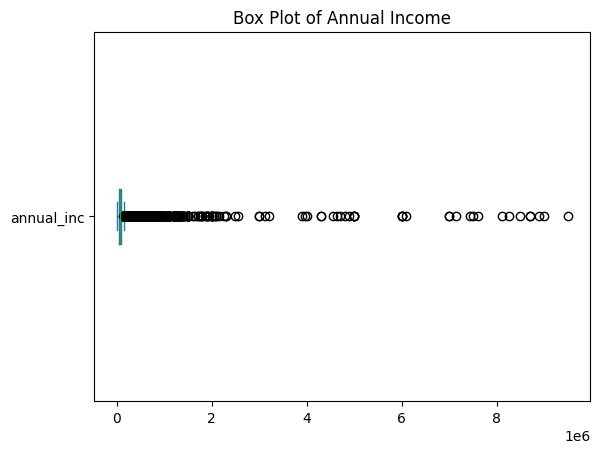

In [82]:
import matplotlib.pyplot as plt
df['annual_inc'].plot(kind='box', vert=False)
plt.title('Box Plot of Annual Income')
plt.show

Meaning we have some values around 9e6 (9,000,000) of annual income. Analyzing descriptive statistics for that column we have:

In [83]:
max_income = df['annual_inc'].max()
print(f"Maximum Annual Income: {max_income}")

min_income = df['annual_inc'].min()
print(f"Minimum Annual Income: {min_income}")

mean_income = df['annual_inc'].mean()
print(f"Mean Annual Income: {mean_income:.2f}")

q1 = df['annual_inc'].quantile(0.25)
q2 = df['annual_inc'].quantile(0.50)
q3 = df['annual_inc'].quantile(0.75)

print(f"Q1 (25th percentile): {q1}")
print(f"Q2 (50th percentile): {q2}")
print(f"Q3 (75th percentile): {q3}")

iqr = q3 - q1
print(f"Interquartile Range (IQR): {iqr}")

upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

print(f"Upper Bound for Outliers: {upper_bound}")
print(f"Lower Bound for Outliers: {lower_bound}")


outliers = df[(df['annual_inc'] < lower_bound) | (df['annual_inc'] > upper_bound)]
print(f"Number of Outliers: {len(outliers)}")

Maximum Annual Income: 9500000.0
Minimum Annual Income: 1896.0
Mean Annual Income: 76341.98
Q1 (25th percentile): 47000.0
Q2 (50th percentile): 65000.0
Q3 (75th percentile): 90000.0
Interquartile Range (IQR): 43000.0
Upper Bound for Outliers: 154500.0
Lower Bound for Outliers: -17500.0
Number of Outliers: 41408


In [84]:
df_high_salary = df[(df['dti'] < 2)].sort_values(by='annual_inc', ascending=False)
df_high_salary.shape

(8517, 24)

In [85]:
df_high_salary.head(30)

,loan_amnt,funded_amnt,term,int_rate,installment,grade,annual_inc,dti,loan_status,purpose,...,sub_grade,home_ownership,emp_length,verification_status,delinq_2yrs,open_acc,total_acc,revol_util,addr_state,emp_length_int
697244,24000.0,24000.0,60.0,7.89,485.38,A,9500000.0,0.12,Current,credit_card,...,A5,MORTGAGE,10+ years,Source Verified,0.0,12.0,31.0,22.0,CA,10
506740,11000.0,11000.0,36.0,6.89,339.10,A,9000000.0,0.08,Current,debt_consolidation,...,A3,MORTGAGE,10+ years,Source Verified,0.0,15.0,29.0,33.8,FL,10
684000,10550.0,10550.0,36.0,15.61,368.88,D,8900060.0,0.09,In Grace Period,debt_consolidation,...,D1,RENT,10+ years,Source Verified,0.0,9.0,11.0,102.1,FL,10
866973,8000.0,8000.0,36.0,13.66,272.11,C,8706582.0,0.11,Charged Off,credit_card,...,C3,MORTGAGE,10+ years,Source Verified,0.0,11.0,18.0,54.1,IL,10
490862,14000.0,14000.0,60.0,10.64,301.89,B,8700000.0,0.18,Current,debt_consolidation,...,B4,MORTGAGE,10+ years,Source Verified,0.0,20.0,32.0,44.9,SC,10
514272,12000.0,12000.0,36.0,9.17,382.55,B,8500021.0,0.22,Current,credit_card,...,B2,MORTGAGE,10+ years,Source Verified,0.0,9.0,21.0,88.9,NY,10
552197,30000.0,30000.0,36.0,12.69,1006.35,C,8253000.0,0.14,Current,debt_consolidation,...,C2,OWN,10+ years,Source Verified,0.0,18.0,26.0,61.5,TX,10
594270,5000.0,5000.0,36.0,8.18,157.10,B,8121180.0,0.48,Current,debt_consolidation,...,B1,MORTGAGE,10+ years,Source Verified,0.0,19.0,36.0,88.0,WY,10
599100,10000.0,10000.0,36.0,6.89,308.27,A,7600000.0,0.09,Current,home_improvement,...,A3,MORTGAGE,3 years,Source Verified,10.0,18.0,27.0,15.7,SC,3
325185,15000.0,15000.0,36.0,19.52,553.80,E,7500000.0,0.20,Current,medical,...,E2,MORTGAGE,10+ years,Verified,2.0,29.0,42.0,27.3,NV,10


All of those 30 values are of clients with an annual salary above 4 million, requesting very small loans for topics like credit card or debt consolidation and a debt to inclome ratio below 2; we decide to consider them typos or extreme outliers and to delete them from the database:

In [86]:
top_30_indices = df_high_salary.head(30).index

df.drop(top_30_indices, inplace=True)

df.reset_index(drop=True, inplace=True)

<function matplotlib.pyplot.show(close=None, block=None)>

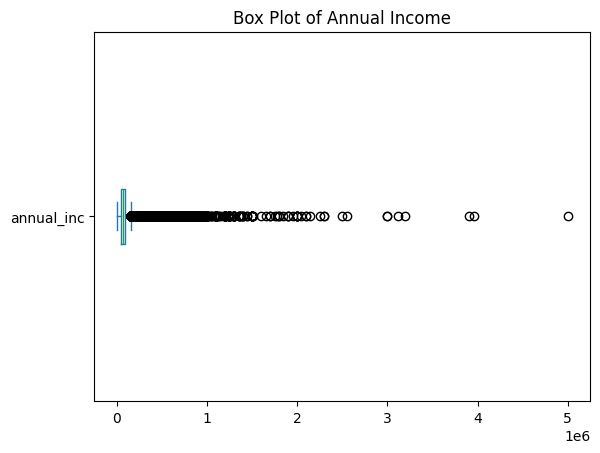

In [87]:
df['annual_inc'].plot(kind='box', vert=False)
plt.title('Box Plot of Annual Income')
plt.show

The database is clean:

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841943 entries, 0 to 841942
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   loan_amnt            841943 non-null  float64       
 1   funded_amnt          841943 non-null  float64       
 2   term                 841943 non-null  float64       
 3   int_rate             841943 non-null  float64       
 4   installment          841943 non-null  float64       
 5   grade                841943 non-null  object        
 6   annual_inc           841943 non-null  float64       
 7   dti                  841943 non-null  float64       
 8   loan_status          841943 non-null  object        
 9   purpose              841943 non-null  object        
 10  total_pymnt          841943 non-null  float64       
 11  total_rec_int        841943 non-null  float64       
 12  total_rec_prncp      841943 non-null  float64       
 13  issue_d       

Save the file with the clean data:

In [89]:
df.to_csv("lc_loan_clean.csv", index=False)